In [1]:
import os
import gc
import copy
import random
import shutil
import typing as tp
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from torch.optim.lr_scheduler import CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.cuda import amp
import timm
import albumentations as A
import albumentations
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import cv2
import time
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
import warnings
warnings.simplefilter('ignore')
import gc
gc.enable()

In [2]:
def set_seed(seed = 0):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state


RANDAM_SEED = 42
random_state = set_seed(RANDAM_SEED)

In [3]:
class ClassificationDataset:
    
    def __init__(self, image_paths, targets0, targets1, targets2, targets3, transform): 
        self.image_paths = image_paths
        self.targets0 = targets0
        self.targets1 = targets1
        self.targets2 = targets2
        self.targets3 = targets3
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):      
        
        image = cv2.imread(self.image_paths[item])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image = image)["image"]
        
        image = image.transpose((2, 0, 1)) / 255.0
        
        
        targets0 = self.targets0[item]
        targets1 = self.targets1[item]
        targets2 = self.targets2[item]
        targets3 = self.targets3[item]
        all_targets = np.argmax([targets0, targets1, targets2, targets3])
                
        return {
            "image": torch.tensor(image, dtype=torch.float),
            "targets0": torch.tensor(all_targets, dtype=torch.float),
        }

In [4]:
def train_one_epoch(data_loader, model, optimizer, device):
    
    criterion = nn.CrossEntropyLoss(weight = class_weights_c)
    model.train()
    
    scaler = amp.GradScaler(enabled=True)
    for data in tqdm(data_loader, position=0, leave=True, desc='Training'):
        
        inputs = data["image"]
        targets0 = data['targets0']
        

        inputs = inputs.to(device, dtype=torch.float)
        targets0 = targets0.to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        
        with amp.autocast(True):
            outputs = model(inputs)
            loss = criterion(outputs, targets0)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
def evaluate(data_loader, model, device):
    model.eval()
    
    final_targets = []
    final_outputs = []
    act = torch.nn.Softmax(dim=1)
    with torch.no_grad():
        
        for data in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            inputs = data["image"]
            targets = data["targets0"]
            
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.long)
            
            output = model(inputs)
            output = act(output)
            
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(output)
            
    return final_outputs, final_targets

In [5]:
train = pd.read_csv("/data0/Salman/alcer/DFUC2021_train/train.csv")
file_names = np.sort(os.listdir("/data0/Salman/alcer/DFUC2021_test/"))
train.head()

,image,none,infection,ischaemia,both
0,301000.jpg,1.0,0.0,0.0,0.0
1,301001.jpg,1.0,0.0,0.0,0.0
2,301002.jpg,0.0,1.0,0.0,0.0
3,301003.jpg,0.0,1.0,0.0,0.0
4,301004.jpg,0.0,1.0,0.0,0.0


In [6]:
valid_df = pd.DataFrame()
valid_df["image"] = file_names
valid_df["none"] = 0
valid_df["infection"] = 0
valid_df["ischaemia"] = 0
valid_df["both"] = 0
print (valid_df.shape)
valid_df.head()

(5734, 5)


,image,none,infection,ischaemia,both
0,501000.jpg,0,0,0,0
1,501001.jpg,0,0,0,0
2,501002.jpg,0,0,0,0
3,501003.jpg,0,0,0,0
4,501004.jpg,0,0,0,0


In [7]:
# valid_df["both"] = 1
# valid_df.to_csv("just3.csv", index=False)

In [8]:
IMG = "/data0/Salman/alcer/DFUC2021_test/" + valid_df["image"]
IMG = IMG.values
T1 = valid_df["none"].values
T2 = valid_df["infection"].values
T3 = valid_df["ischaemia"].values
T4 = valid_df["both"].values

In [9]:
N_FOLDS = 5
n = 4
n_workers = 16
device = "cuda:2"
Batch_Size = 64
warmup_epo = 1
init_lr = 1e-4
cosine_epo = 89
n_epochs = warmup_epo + cosine_epo
baseline_name = "tf_efficientnet_b0"

In [10]:
class CustomModel(nn.Module):
    def __init__(self, model_name, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=n)

    def forward(self, x):
        output = self.model(x)
        return output

In [11]:
preds = []
for fold in range(0, N_FOLDS):
    model = CustomModel(baseline_name, pretrained=True)
    model.load_state_dict(torch.load("/data0/Salman/alcer/models/" + baseline_name + '-' + str(fold) + '.pt'))
    model.to(device)
    valid_dataset = ClassificationDataset(IMG, T1, T2, T3, T4, None)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=Batch_Size,shuffle=False, num_workers=n_workers)
    predictions, valid_targets = evaluate(valid_loader, model, device=device)
    predictions = np.array(predictions)
    preds.append(predictions)

Evaluating:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/90 [00:00<?, ?it/s]

In [25]:
# fold = 1
# model = CustomModel(model_name=baseline_name, pretrained=True)
# model.load_state_dict(torch.load("/data0/Salman/alcer/models/" + baseline_name + '-' + str(fold) + '.pt'))
# model.to(device)
# valid_dataset = ClassificationDataset(IMG, T1, T2, T3, T4, None)
# valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=Batch_Size,shuffle=False, num_workers=n_workers)
# predictions1, valid_targets = evaluate(valid_loader, model, device=device)
# predictions1 = np.array(predictions1)

In [12]:
predictions = (preds[0] + preds[1] + preds[2] + preds[3] + preds[4]) / 5.0
#predictions = preds[0]

In [13]:
np.unique(np.round(predictions), return_counts=True)

(array([0., 1.]), array([17361,  5575]))

In [14]:
valid_df["none"] = predictions[:, 0]
valid_df["infection"] = predictions[:, 1]
valid_df["ischaemia"] = predictions[:, 2]
valid_df["both"] = predictions[:, 3]

In [15]:
valid_df.head()

,image,none,infection,ischaemia,both
0,501000.jpg,0.004207,0.973990,2.438361e-10,2.180239e-02
1,501001.jpg,0.000030,0.000045,6.743720e-01,3.255528e-01
2,501002.jpg,0.574974,0.425009,5.225833e-07,1.715941e-05
3,501003.jpg,0.364810,0.635173,1.712721e-05,5.263029e-09
4,501004.jpg,0.002717,0.105456,7.719445e-01,1.198824e-01


In [16]:
valid_df.to_csv("efb089submission.csv", index=False)

In [24]:
np.unique(np.round(predictions), return_counts=True)

(array([0., 1.]), array([1501,  499]))

In [16]:
np.unique(np.argmax(predictions, axis=1), return_counts=True)

(array([0, 1, 2, 3]), array([265, 170,  34,  31]))

In [15]:
np.unique(np.argmax(predictions, axis=1), return_counts=True)

(array([0, 1, 2, 3]), array([277, 153,  28,  42]))

In [14]:
np.unique(np.argmax(predictions, axis=1), return_counts=True)

(array([0, 1, 2, 3]), array([279, 143,  35,  43]))

In [3]:
w = np.array([279, 143,  35,  43])
w = w / 500
w

array([0.558, 0.286, 0.07 , 0.086])

In [3]:
w = np.array([219, 229,  15,  37])
w = w / 500
w

array([0.438, 0.458, 0.03 , 0.074])

In [3]:
w = np.array([218, 223,  17,  42])
w = w / 500
w

array([0.436, 0.446, 0.034, 0.084])

In [6]:
df1 = pd.read_csv("v0submission.csv")
df2 = pd.read_csv("v3submission.csv")
df1.head()

,image,none,infection,ischaemia,both
0,501000.jpg,0.253046,0.706096,2.554320e-08,4.085783e-02
1,501001.jpg,0.000620,0.000231,7.639602e-01,2.351890e-01
2,501002.jpg,0.782657,0.217342,2.452433e-08,1.431568e-06
3,501003.jpg,0.401719,0.598281,4.937007e-08,1.383018e-09
4,501004.jpg,0.082277,0.016829,6.026488e-01,2.982452e-01


In [7]:
# df1["none"] = 0.7*df1["none"] + 0.3*df2["none"]
# df1["infection"] = 0.7*df1["infection"] + 0.3*df2["infection"]
df1["ischaemia"] = 0.3*df1["ischaemia"] + 0.7*df2["ischaemia"]
# df1["both"] = 0.7*df1["both"] + 0.3*df2["both"]
df1.head()

,image,none,infection,ischaemia,both
0,501000.jpg,0.253046,0.706096,9.449113e-07,4.085783e-02
1,501001.jpg,0.000620,0.000231,9.134075e-01,2.351890e-01
2,501002.jpg,0.782657,0.217342,5.468704e-07,1.431568e-06
3,501003.jpg,0.401719,0.598281,2.408193e-05,1.383018e-09
4,501004.jpg,0.082277,0.016829,7.797446e-01,2.982452e-01


In [9]:
df1.to_csv("v3-0submission.csv", index=False)

In [17]:
df = pd.read_csv("efb089submission.csv")
df["both"] = df["both"] ** 0.55
df["ischaemia"] = df["ischaemia"] ** 2.2
df["infection"] = df["infection"] ** 0.4
df["none"] = df["none"] ** 1.6
df.head()

,image,none,infection,ischaemia,both
0,501000.jpg,1.579067e-04,0.989514,7.105841e-22,0.121949
1,501001.jpg,5.803213e-08,0.018282,4.203190e-01,0.539438
2,501002.jpg,4.125122e-01,0.710165,1.513360e-14,0.002393
3,501003.jpg,1.992078e-01,0.833982,3.266712e-11,0.000028
4,501004.jpg,7.844899e-05,0.406657,5.658345e-01,0.311398


In [19]:
np.unique(np.argmax(df[['none', 'infection', 'ischaemia', 'both']].values, axis=1), return_counts=True)[1] / df.shape[0]

array([0.44070457, 0.4267527 , 0.03243809, 0.10010464])

In [20]:
df.to_csv("moded_v0_89_test.csv", index=False)

In [38]:
df = pd.read_csv("efb0-submission.csv")
df["both"] = df["both"] ** 0.55
df["ischaemia"] = df["ischaemia"] ** 2.2
df["infection"] = df["infection"] ** 0.4
df["none"] = df["none"] ** 1.6
np.unique(np.argmax(df[['none', 'infection', 'ischaemia', 'both']].values, axis=1), return_counts=True)

(array([0, 1, 2, 3]), array([218, 223,  17,  42]))

In [39]:
df.to_csv("modedb0.csv", index=False)

In [41]:
df = pd.read_csv("efb0-submission.csv")
np.unique(np.argmax(df[['none', 'infection', 'ischaemia', 'both']].values, axis=1), return_counts=True)

(array([0, 1, 2, 3]), array([261, 177,  34,  28]))

Text(0.5, 0.98, 'Comparison of Softmax Probabilities and Bias Adjusted Probabilities for each class')

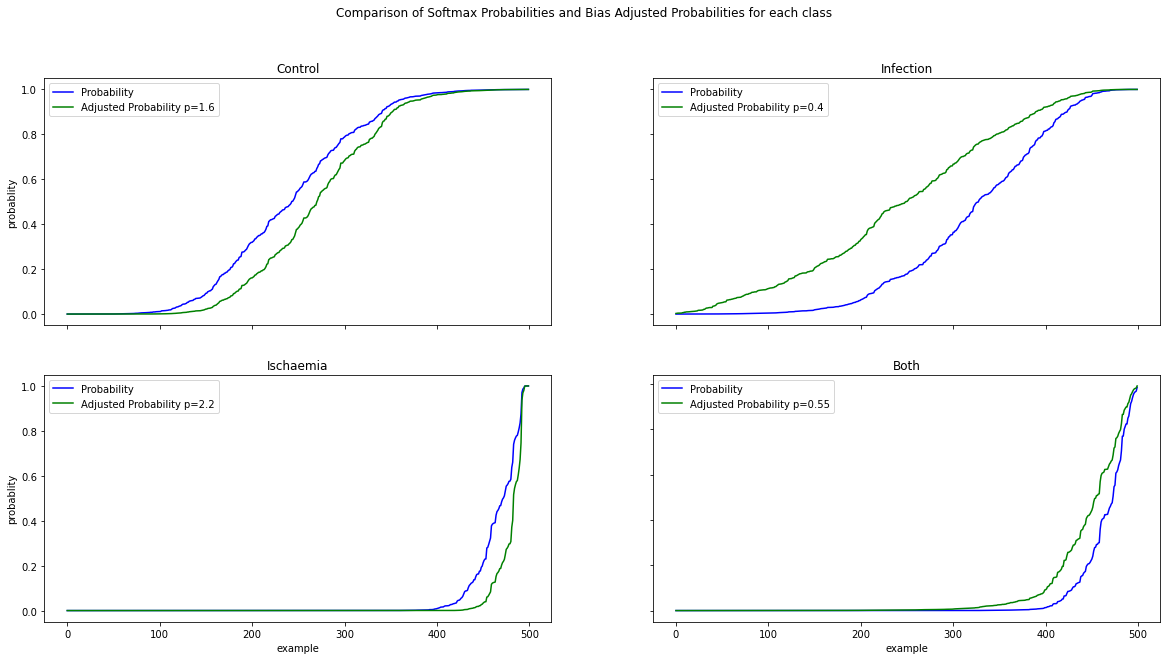

In [40]:
fig, axs = plt.subplots(2, 2)
v = df["none"].values
vv = v**1.6
axs[0, 0].plot(list(range(0, df.shape[0])), v[np.argsort(v)], 'b', label='Probability')
axs[0, 0].plot(list(range(0, df.shape[0])), vv[np.argsort(v)], 'g', label='Adjusted Probability p=1.6')
axs[0, 0].set_title('Control')

v = df["infection"].values
vv = v**0.4
axs[0, 1].plot(list(range(0, df.shape[0])), v[np.argsort(v)], 'b', label='Probability')
axs[0, 1].plot(list(range(0, df.shape[0])), vv[np.argsort(v)], 'g', label='Adjusted Probability p=0.4')
axs[0, 1].set_title('Infection')

v = df["ischaemia"].values
vv = v**2.2
axs[1, 0].plot(list(range(0, df.shape[0])), v[np.argsort(v)], 'b', label='Probability')
axs[1, 0].plot(list(range(0, df.shape[0])), vv[np.argsort(v)], 'g', label='Adjusted Probability p=2.2')
axs[1, 0].set_title('Ischaemia')

v = df["both"].values
vv = v**0.55
axs[1, 1].plot(list(range(0, df.shape[0])), v[np.argsort(v)], 'b', label='Probability')
axs[1, 1].plot(list(range(0, df.shape[0])), vv[np.argsort(v)], 'g', label='Adjusted Probability p=0.55')
axs[1, 1].set_title('Both')


for ax in axs.flat:
    ax.set(xlabel='example', ylabel='probablity')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.legend()
fig.suptitle('Comparison of Softmax Probabilities and Bias Adjusted Probabilities for each class')

Text(0.5, 0.98, 'Comparison of Softmax Probabilities and Bias Adjusted Probabilities for each class')

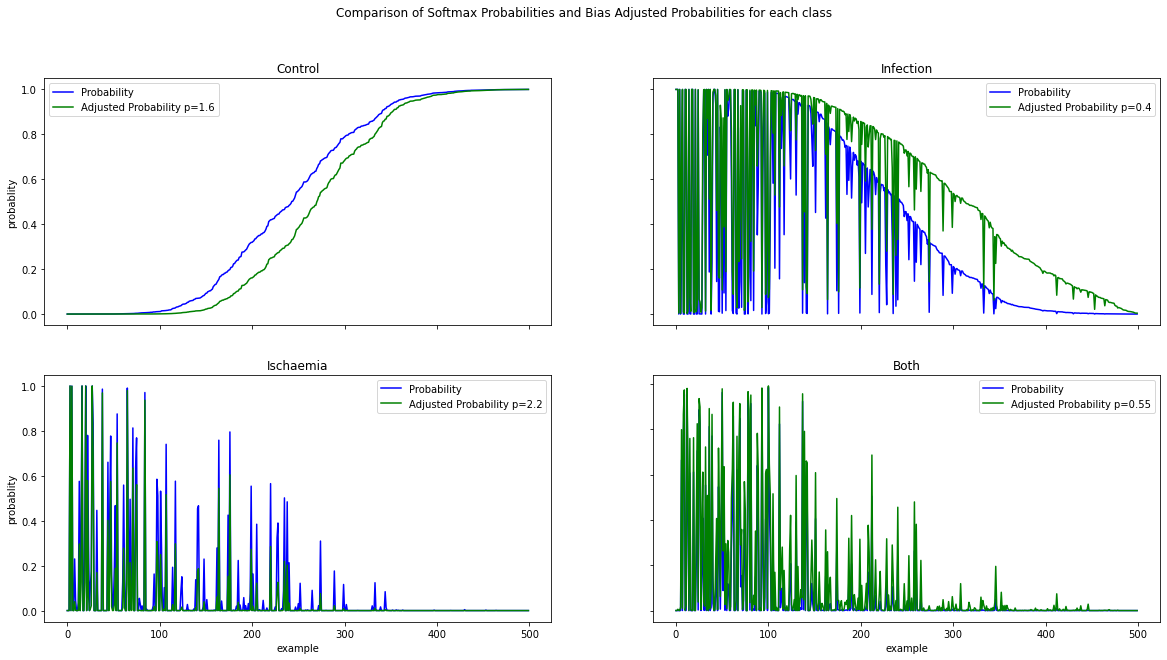

In [45]:
fig, axs = plt.subplots(2, 2)
v = df["none"].values
srt = np.argsort(v)
vv = v**1.6
axs[0, 0].plot(list(range(0, df.shape[0])), v[srt], 'b', label='Probability')
axs[0, 0].plot(list(range(0, df.shape[0])), vv[srt], 'g', label='Adjusted Probability p=1.6')
axs[0, 0].set_title('Control')

v = df["infection"].values
vv = v**0.4
axs[0, 1].plot(list(range(0, df.shape[0])), v[srt], 'b', label='Probability')
axs[0, 1].plot(list(range(0, df.shape[0])), vv[srt], 'g', label='Adjusted Probability p=0.4')
axs[0, 1].set_title('Infection')

v = df["ischaemia"].values
vv = v**2.2
axs[1, 0].plot(list(range(0, df.shape[0])), v[srt], 'b', label='Probability')
axs[1, 0].plot(list(range(0, df.shape[0])), vv[srt], 'g', label='Adjusted Probability p=2.2')
axs[1, 0].set_title('Ischaemia')

v = df["both"].values
vv = v**0.55
axs[1, 1].plot(list(range(0, df.shape[0])), v[srt], 'b', label='Probability')
axs[1, 1].plot(list(range(0, df.shape[0])), vv[srt], 'g', label='Adjusted Probability p=0.55')
axs[1, 1].set_title('Both')


for ax in axs.flat:
    ax.set(xlabel='example', ylabel='probablity')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.legend()
fig.suptitle('Comparison of Softmax Probabilities and Bias Adjusted Probabilities for each class')